In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import pandas as pd
import shutil
import math
from PIL import Image

# Slice tiff image into many pngs

Specify output resolution and initial patch size. For example, you can cut the tiff into 256 x 256 patches, then downsample to 64 x 64

In [ ]:
out_res = 64

def read_tiff_to_np(path):
    img = tiff.imread(path)
    arr = np.array(img)
    return arr

# put the brightness into all 3 channels
def tiff_to_png(arr, arr_min, arr_max):
    arr = ((arr - arr_min) / (arr_max - arr_min)) * 255
    arr = arr.astype(np.int16)
    # arr = arr[:, :, np.newaxis]
    # arr = np.tile(arr, (1, 1, 3))
    img = Image.fromarray(arr)
    img = img.resize((out_res, out_res))
    return img

def make_patches(data, out_path, slice_size):
    if not os.path.exists(out_path):
        os.mkdir(out_path)

    arr = read_tiff_to_np(data)
    arr_max = np.max(arr)
    arr_min = np.min(arr)
    assert arr.shape[0] == arr.shape[1]
    num_slices = arr.shape[0] // slice_size
    for i in range(num_slices):
        for j in range(num_slices):
            sample = arr[i * slice_size: i * slice_size + slice_size, 
                        j * slice_size: j * slice_size + slice_size]
            img = tiff_to_png(sample, arr_min, arr_max)
            img.save(os.path.join(out_path, f'{i}-{j}.png'), format = 'PNG')

sierra = '../data/USGS_1M_10_x76y415_CA_SierraNevada_B22.tif'
gc = '../data/USGS_13_n37w113_20250805.tif'

make_patches(sierra, '../data/sierra_256', 256)
make_patches(gc, '../data/gc_256', 256)

/tmp/ipykernel_801/3983023534.py:17: DeprecationWarning: Saving I mode images as PNG is deprecated and will be removed in Pillow 13 (2026-10-15)
  img.save(os.path.join(out_path, f'{i}-{j}.png'), format = 'PNG')


# Create train/test split and copy data to new directories

In [ ]:
def test_train_split(dirs, train_ratio = .95):
    rng = np.random.default_rng(seed = 31415)
    data = []
    for d in dirs:
        for f in os.listdir(d):
            data.append(os.path.join(d, f))
    
    train = rng.choice(data, size = int(len(data) * train_ratio), replace = False)
    test = [file for file in data if file not in train]
    return train, test

def copy_ims(ims, out_dir):
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.mkdir(out_dir)

    for idx, im in enumerate(ims):
        shutil.copy(im, os.path.join(out_dir, f'{idx}.png'))

train, test = test_train_split(['../data/gc_256', '../data/sierra_256'])

train_dir = '../data/train_geo'
test_dir = '../data/test_geo'

copy_ims(train, train_dir)
copy_ims(test, test_dir)

# Calculate mean, std

In [139]:
data_dir = '../data/train_geo'
total = 0
squared_sum = 0
total_pixels = len(os.listdir(data_dir)) * 64 * 64
for im_name in os.listdir(data_dir):
    im = np.array(Image.open(os.path.join(data_dir, im_name))) / 255
    total += np.sum(im)
    squared_sum += np.sum(im ** 2)

mean = total / total_pixels
std = math.sqrt((squared_sum / total_pixels) - (mean**2))
print(mean, std)

0.5256495484687265 0.17987073002373147


# Visualize patches

1.png


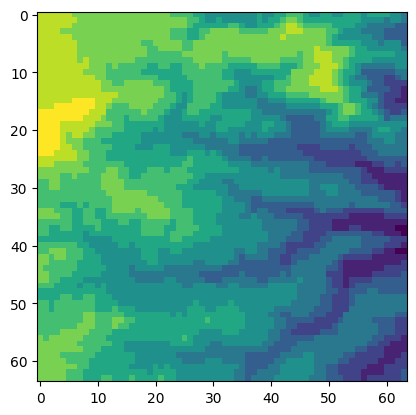

In [155]:
dataset = '../data/test_geo'

patches = os.listdir(dataset)
patch = np.random.choice(patches)
print(patch)

img = Image.open(os.path.join(dataset, patch))
arr = np.array(img)
plt.imshow(img, cmap = 'viridis')